In [1]:
LOAD = True

In [2]:
import numpy as np
np.random.seed(1001)

import os
import shutil

import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold

import wave
from scipy.io import wavfile

import librosa
import numpy as np
import scipy

from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K
from keras.models import Sequential

%matplotlib inline
matplotlib.style.use('ggplot')

/home/ankur16225/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test_post_competition.csv")

In [4]:
train.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [5]:
# Remove None Label from test data
test.drop(test[test.label == 'None'].index, inplace=True)
test.head()

,fname,label,usage,freesound_id,license
4,00326aa9.wav,Oboe,Private,355125,Attribution
5,0038a046.wav,Bass_drum,Private,90621,Creative Commons 0
8,007759c4.wav,Saxophone,Private,13406,Creative Commons 0
9,008afd93.wav,Saxophone,Private,358962,Attribution
12,00ae03f6.wav,Chime,Private,78203,Attribution


In [6]:
print('No. of Classes: ', len(train.label.unique()))
print('No. of Training Samples: {}, No. of Test Samples: {}'.format(len(train), len(test)))

No. of Classes:  41
No. of Training Samples: 9473, No. of Test Samples: 1600


In [7]:
# print('Minimum samples per category = ', min(test.label.value_counts()))
# print('Maximum samples per category = ', max(test.label.value_counts()))

#### Hyper-parameters

In [8]:
SAMPLING_RATE = 44100
DURATION = 2
CLASSES = 41
LEARNING_RATE = .001
MAX_EPOCHS = 50
BATCH_SIZE = 32
AUDIO_LENGTH = SAMPLING_RATE * DURATION
N_MFCC = 40
DIM = (N_MFCC, 1 + int(np.floor(AUDIO_LENGTH/512)), 1)

#### MFCC Model

In [9]:
def build_model():
    inp = Input(shape=(DIM[0], DIM[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(CLASSES, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(LEARNING_RATE)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [10]:
from keras.utils.vis_utils import plot_model
model = build_model()
plot_model(model, to_file='model_plot.png')

In [11]:
LABELS = list(train.label.unique())
label_idx = {label: i for i, label in enumerate(LABELS)}
train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)
train["label_idx"] = train.label.apply(lambda x: label_idx[x])
test["label_idx"] = test.label.apply(lambda x: label_idx[x])

In [12]:
def prepare_data(df, data_dir):
    X = np.empty(shape=(df.shape[0], DIM[0], DIM[1], 1))
    input_length = AUDIO_LENGTH
    for i, fname in tqdm_notebook(enumerate(df.index)):
        file_path = data_dir + fname
        data, _ = librosa.core.load(file_path, sr=SAMPLING_RATE, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=SAMPLING_RATE, n_mfcc=N_MFCC)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [13]:
if not LOAD:
    X_train = prepare_data(train, '../data/audio_train/')
    X_test = prepare_data(test, '../data/audio_test/')

In [14]:
y_train = to_categorical(train.label_idx, num_classes=CLASSES)
y_test = to_categorical(test.label_idx, num_classes=CLASSES)

In [15]:
# Normalization
if not LOAD:
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train = (X_train - mean)/std
    X_test = (X_test - mean)/std

### Training..

In [16]:
PREDICTION_FOLDER = "predictions"
if not LOAD:
    if not os.path.exists(PREDICTION_FOLDER):
        os.mkdir(PREDICTION_FOLDER)
    if os.path.exists('logs/' + PREDICTION_FOLDER):
        shutil.rmtree('logs/' + PREDICTION_FOLDER)

In [17]:
if not LOAD:
    K.clear_session()

    checkpoint = ModelCheckpoint('best_weights.h5', monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER, write_graph=True)
    callbacks_list = [checkpoint, early, tb]

    model = build_model()

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=callbacks_list, 
                        batch_size=64, epochs=MAX_EPOCHS)

    model.save_weights('weights_final.h5')

In [18]:
# load best weights
model = build_model()
model.load_weights('weights_final.h5')

In [19]:
if not LOAD:
    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + '/train_predictions.npy', predictions)
    train_eval = model.evaluate(x=X_train, y=y_train, batch_size=64, verbose=1)
    print('Training Accuracy: ', train_eval[1])

predictions = np.load(PREDICTION_FOLDER + '/train_predictions.npy')
from sklearn.metrics import classification_report
print('Train Classification Report:')
print(classification_report(np.argmax(y_train, axis=1), np.argmax(predictions, axis=1)))

Train Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       300
           1       0.91      0.99      0.95       300
           2       0.98      0.89      0.93       300
           3       0.70      1.00      0.82        94
           4       0.99      0.85      0.92       300
           5       0.93      0.91      0.92       279
           6       0.86      0.73      0.79       147
           7       1.00      0.98      0.99       300
           8       0.99      0.75      0.85       119
           9       0.89      0.91      0.90       139
          10       0.98      0.91      0.94       300
          11       0.73      0.92      0.81       270
          12       0.81      0.98      0.89       300
          13       0.99      0.72      0.83       300
          14       0.98      0.83      0.90       300
          15       0.98      1.00      0.99       299
          16       0.99      0.91      0.95       30

In [23]:
if not LOAD:
    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + '/test_predictions.npy', predictions)
    test_eval = model.evaluate(x=X_test, y=y_test, batch_size=64, verbose=1)
    print('Test Accuracy: ', test_eval[1])

predictions = np.load(PREDICTION_FOLDER + '/test_predictions.npy')

from sklearn.metrics import classification_report
print('Test Classification Report:')
cr = classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))
print(cr)

Test Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.54      0.62        39
           1       0.74      0.72      0.73       110
           2       0.72      0.70      0.71        37
           3       0.44      0.62      0.51        29
           4       0.84      0.69      0.76        54
           5       0.67      0.67      0.67        39
           6       0.81      0.27      0.40        63
           7       0.75      0.80      0.78        56
           8       0.67      0.15      0.25        26
           9       0.50      0.50      0.50        28
          10       0.69      0.74      0.71        34
          11       0.21      0.41      0.28        29
          12       0.39      0.74      0.51        38
          13       0.41      0.41      0.41        27
          14       0.55      0.40      0.46        30
          15       0.78      0.93      0.85        42
          16       0.66      0.69      0.67        55

In [21]:
# Calculate top3 accuracy
test.reset_index(inplace=True)
test.drop(['fname', 'usage', 'freesound_id', 'license'], axis=1, inplace=True)
top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test['predicted_label'] = predicted_labels
top3_acc = 0.
for index, row in test.iterrows():
    if row['label'] in row['predicted_label'].split():
        top3_acc += 1
top3_acc /= len(test)
print('Test Top3 Accuracy: ', top3_acc)

Test Top3 Accuracy:  0.804375


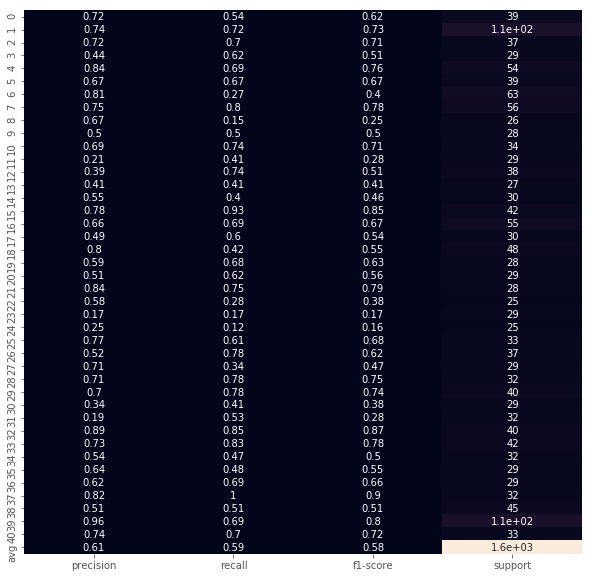

In [29]:
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

y = np.random.randint(low=0, high=10, size=100)
y_p = np.random.randint(low=0, high=10, size=100)

def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                ax=ax)

plot_classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

In [1]:
plot_classification_report(cr)
plt.savefig('test_plot_classif_report.png', dpi=200, format='png', bbox_inches='tight')
plt.close()